# Alphalens: predictive vs. non-predictive factor

This is a very simply notebook in which we use Alphalens to analyse a predictive and a non-predictive factor. The goal is to have exemplifying output for both scenarios to make clear what to expect from Alphalens in the case of a predictive and a non-preditive factor. 

In [1]:
# %pylab inline --no-import-all
import alphalens
import pandas as pd
import numpy as np
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

Below is a simple mapping of tickers to sectors for a universe of 500 large cap stocks.

The pricing data passed to alphalens should contain the entry price for the assets so it must reflect the next available price after a factor value was observed at a given timestamp. Those prices must not be used in the calculation of the factor values for that time. Always double check to ensure you are not introducing lookahead bias to your study.

The pricing data must also contain the exit price for the assets, for period 1 the price at the next timestamp will be used, for period 2 the price after 2 timestamps will be used and so on.

There are no restrinctions/assumptions on the time frequencies a factor should be computed at and neither on the specific time a factor should be traded (trading at the open vs trading at the close vs intraday trading), it is only required that factor and price DataFrames are properly aligned given the rules above.

In our example, before the trading starts every day, we observe yesterday factor values. The price we pass to alphalens is the next available price after that factor observation: the daily open price that will be used as assets entry price. Also, we are not adding additional prices so the assets exit price will be the following days open prices (how many days depends on 'periods' argument). The retuns computed by Alphalens will therefore based on  assets open prices.

# 数据

In [3]:
from pathlib import Path
fp_sector = Path('sector.pkl')
fp_pricing = Path('b_open.pkl')

from zipline.research import get_pricing, get_sector_mappings
if not fp_sector.exists():
    # asset -> sector name
    sector_mappings = get_sector_mappings()
    tickers = np.random.choice(list(sector_mappings.keys()), 100)
    sector_mappings = {k:sector_mappings[k] for k in tickers}
    s = pd.Series(sector_mappings)
    s.to_pickle(str(fp_sector))
    
sector_mappings = pd.read_pickle(str(fp_sector)).to_dict()

if not fp_pricing.exists():
    pricing = get_pricing(sector_mappings.keys(), start_date, end_date, fields='b_open')
    pricing.to_pickle(str(fp_pricing))
    
pricing = pd.read_pickle(str(fp_pricing))

We'll use a naive factor as non-predictive factor, we'll rank stocks based on recent performance: stocks that performed well in the last 10 days will have high rank and vice versa.

In [4]:
non_predictive_factor = pricing.pct_change(10)

non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])

To create a predictive factor we'll cheat: we will look at future prices to make sure we'll rank high stoks that will perform well and vice versa.

In [5]:
lookahead_bias_days = 5

predictive_factor = pricing.pct_change(lookahead_bias_days)
# introduce look-ahead bias and make the factor predictive
predictive_factor = predictive_factor.shift(-lookahead_bias_days)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

# Run Alphalens on the non-predictive factor

In [6]:
non_predictive_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(non_predictive_factor, 
                                                                                  pricing, 
                                                                                  quantiles=5,
                                                                                  bins=None,
                                                                                  groupby=sector_mappings)
#                                                                                   groupby_labels=sector_names)

Dropped 2.9% entries from factor data: 2.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [7]:
alphalens.tears.create_full_tear_sheet(non_predictive_factor_data, by_group=True)

# Run Alphalens on the predictive factor

In [8]:
predictive_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(predictive_factor, 
                                                                              pricing, 
                                                                              quantiles=5,
                                                                              bins=None,
                                                                              groupby=sector_mappings)
#                                                                               groupby_labels=sector_names)

Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [9]:
alphalens.tears.create_full_tear_sheet(predictive_factor_data, by_group=True)

# Run Event Style Returns Analysis

In [12]:
returns = pricing.pct_change().fillna(0.0)

## Non-predictive factor

In [13]:
alphalens.tears.create_event_returns_tear_sheet(non_predictive_factor_data, returns)

## Predictive factor

In [14]:
alphalens.tears.create_event_returns_tear_sheet(predictive_factor_data, returns)

In [15]:
import alphalens as al

In [17]:
avg_cumulative_returns=al.performance.average_cumulative_return_by_quantile(predictive_factor_data, returns)

In [18]:
avg_cumulative_returns

-10       -9        -8        -7        -6   \
factor_quantile                                                          
1               mean  0.002203  0.002589  0.002011  0.003022  0.002698   
                std   0.008422  0.009577  0.008824  0.008830  0.009297   
2               mean -0.000511 -0.000749 -0.000167 -0.000806 -0.000972   
                std   0.006363  0.006174  0.006553  0.006629  0.005917   
3               mean -0.001150 -0.001392 -0.001563 -0.001220 -0.001142   
                std   0.005736  0.005566  0.005746  0.005951  0.006451   
4               mean -0.000863 -0.000670 -0.000709 -0.001034 -0.000826   
                std   0.006851  0.006393  0.006783  0.006593  0.006459   
5               mean  0.000251  0.000157  0.000347 -0.000041  0.000168   
                std   0.006617  0.006990  0.006891  0.006446  0.006594   

                           -5        -4        -3        -2        -1   ...  \
factor_quantile                                                         ...   
1               mean  0.002705  0.002463  0.002819  0.002487  0.003317  ...   
                std   0.009691  0.008993  0.009084  0.009118  0.008879  ...   
2               mean -0.000537 -0.000843 -0.001705 -0.001370 -0.001743  ...   
                std   0.006334  0.006141  0.005634  0.006219  0.005400  ...   
3               mean -0.001654 -0.001487 -0.001319 -0.001508 -0.001911  ...   
                std   0.005705  0.005770  0.005867  0.006359  0.005968  ...   
4               mean -0.001173 -0.001443 -0.001326 -0.000771 -0.001061  ...   
                std   0.006132  0.005970  0.006199  0.005871  0.006347  ...   
5               mean  0.000582  0.001229  0.001442  0.001056  0.001279  ...   
                std   0.006718  0.006867  0.006959  0.007295  0.007526  ...   

                            6         7         8         9         10  \
factor_quantile                                                          
1               mean  0.000388 -0.000048 -0.000930 -0.000197  0.000168   
                std   0.007155  0.006636  0.006492  0.006924  0.006704   
2               mean  0.001048  0.000223  0.000659  0.000620  0.000228   
                std   0.006222  0.006441  0.006716  0.006081  0.006322   
3               mean  0.000055  0.000515  0.000275  0.000247 -0.000072   
                std   0.005878  0.005958  0.005976  0.005764  0.005846   
4               mean  0.000103  0.000471  0.000581  0.000141 -0.000145   
                std   0.006744  0.006478  0.006347  0.007036  0.006674   
5               mean -0.001599 -0.001153 -0.000567 -0.000773 -0.000188   
                std   0.010612  0.010189  0.010365  0.009005  0.008604   

                            11        12        13        14        15  
factor_quantile                                                         
1               mean  0.000126 -0.000007  0.000272 -0.000167  0.000144  
                std   0.006635  0.006774  0.006911  0.007277  0.006866  
2               mean -0.000136  0.000189  0.000142  0.000442 -0.000184  
                std   0.006671  0.006405  0.005986  0.006130  0.006311  
3               mean  0.000415  0.000917  0.000055  0.000075 -0.000019  
                std   0.006149  0.006171  0.005919  0.006574  0.006090  
4               mean  0.000169 -0.000712  0.000099 -0.000202  0.000722  
                std   0.006897  0.006264  0.007076  0.005952  0.006958  
5               mean -0.000571 -0.000376 -0.000572 -0.000155 -0.000646  
                std   0.008300  0.007980  0.008179  0.008237  0.007520  

[10 rows x 26 columns]

<AxesSubplot:>

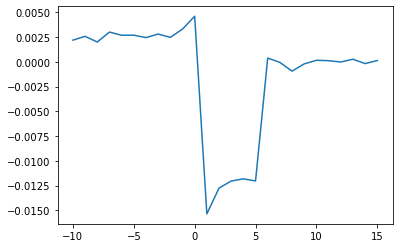

In [20]:
avg_cumulative_returns.loc[(1,'mean'),:].plot()